In [2]:
exp_folder = r"Eyes Closed\test"
exp_condition = r"EC_test"
freq_range = [1,30]
# note: probably have to re-preprocess the data with higher high-cutoff frequency than the used freq in here
# to avoid that part of the higher frequency spectra gets cut off which affects model fitting

Files in folder: 9


,Exponent,Offset,Peaks_CF,Peaks_PW,Peaks_BW,R_2,Error
OKTOS_0001_00A_EC,1.11913,0.884507,"[7.100632405763381, 9.185121114128611, 13.1231...","[1.0412523910944533, 0.6630501252502863, 0.360...","[1.0970425105271586, 1.8595203072165196, 2.005...",0.991829,0.034938
OKTOS_0002_00A_EC,0.91267,0.535624,"[10.205308437986142, 20.583355720394366]","[1.017178069487411, 0.1998722465512291]","[1.4811080484575079, 1.6218947562687034]",0.967153,0.049569
OKTOS_0003_00A_EC,1.238713,1.02934,"[9.775680406434708, 16.568382804284514]","[0.1219412245747821, 0.16356343588248023]","[1.35771247845725, 2.5815008853749886]",0.97698,0.053055
OKTOS_0006_00A_EC,0.658148,0.646231,8.725377,1.256788,3.37219,0.950158,0.091124
OKTOS_0007_00A_EC,1.055791,0.862832,"[10.424371635972056, 14.648293260728575, 17.75...","[0.6892862720398787, 0.5808901542989198, 0.619...","[4.085173933214609, 2.1854676177067915, 4.9162...",0.981141,0.047183
OKTOS_0008_00A_EC,1.335057,1.10914,"[13.286330037387614, 18.452090822806202, 22.99...","[0.42829872668698427, 0.39713576840133313, 0.3...","[5.046135156572569, 5.5923548784436985, 3.2080...",0.976969,0.049944
OKTOS_0010_06D_EC,0.791782,0.7874,"[8.205468022674218, 8.679932366434963, 10.2272...","[0.635232694627843, 0.9286452152735614, 1.4032...","[2.0071593210847687, 1.0443075943560132, 1.207...",0.984997,0.042249
OKTOS_0012_06D_EC,1.015012,0.550576,"[10.526810930897646, 16.14612602415979, 19.588...","[1.037362987317428, 0.2392520267983389, 0.3364...","[2.73552579701513, 3.1379663389537344, 3.97852...",0.986124,0.042796
OKTOS_0016_06D_EC,0.744219,0.628021,"[7.939593827895152, 9.686883804034725, 17.4519...","[1.2084813956903666, 0.4313861849814115, 0.158...","[1.1307023709745203, 1.596283228634919, 4.4276...",0.96004,0.052298


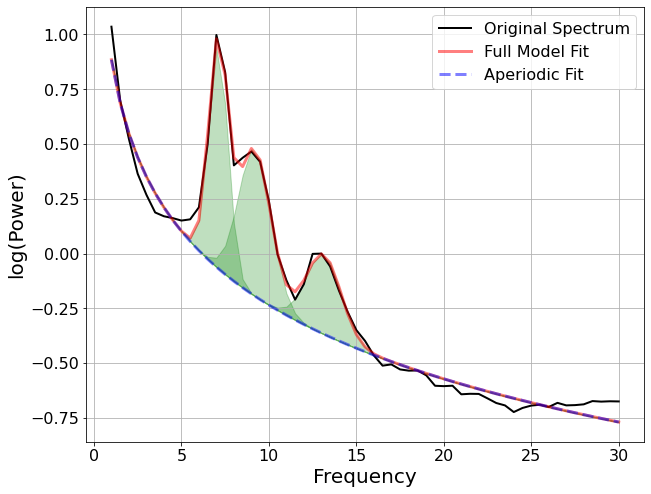

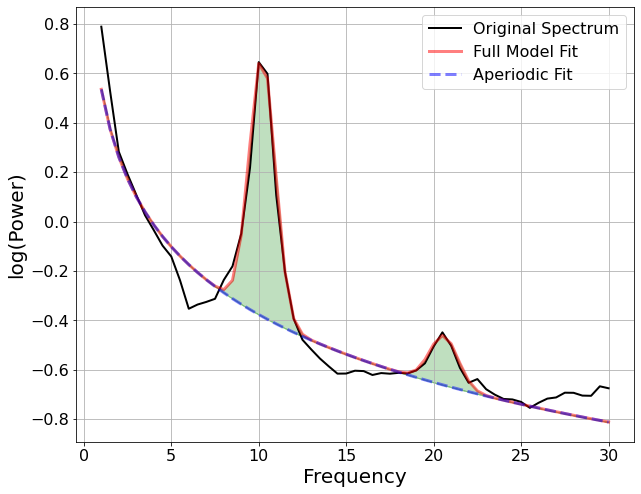

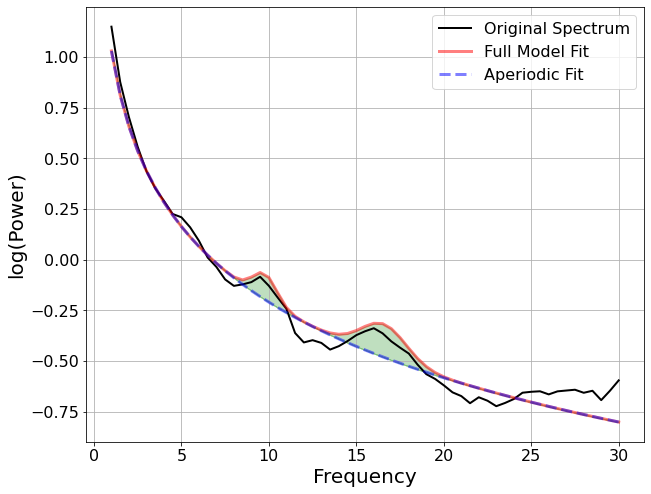

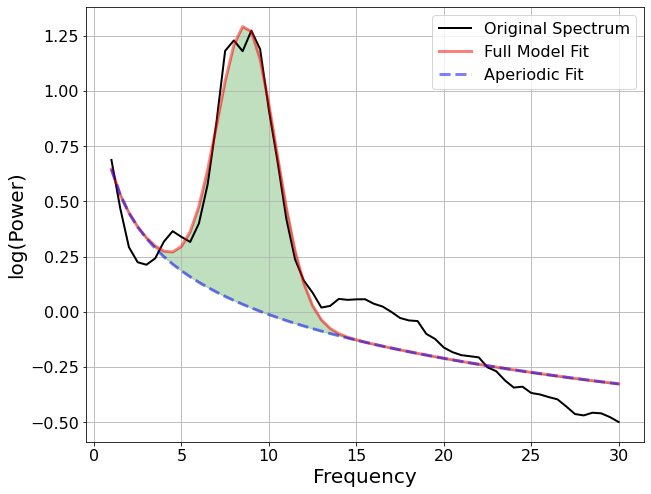

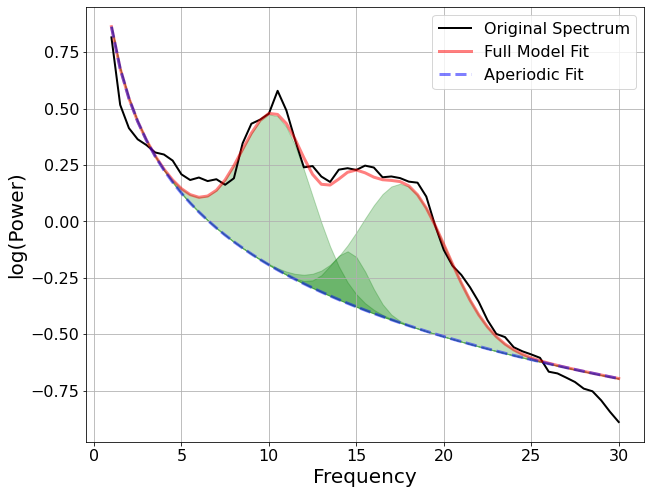

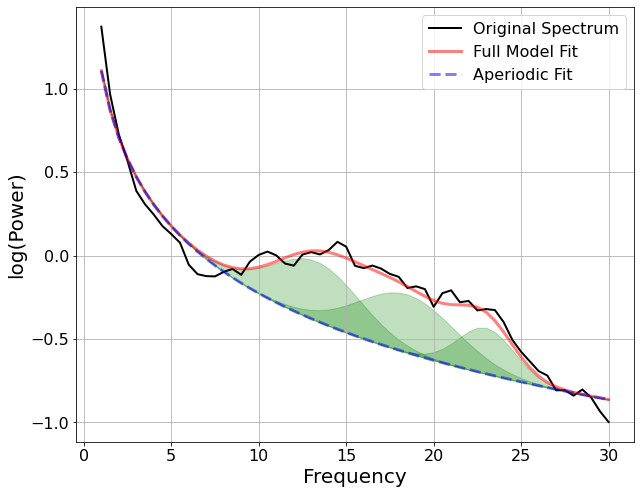

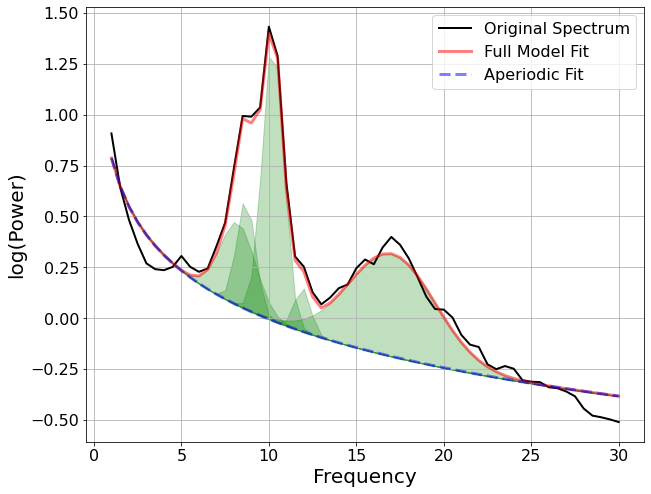

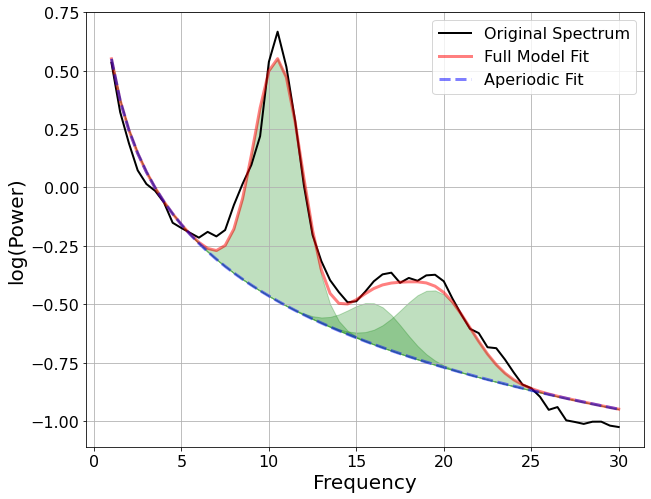

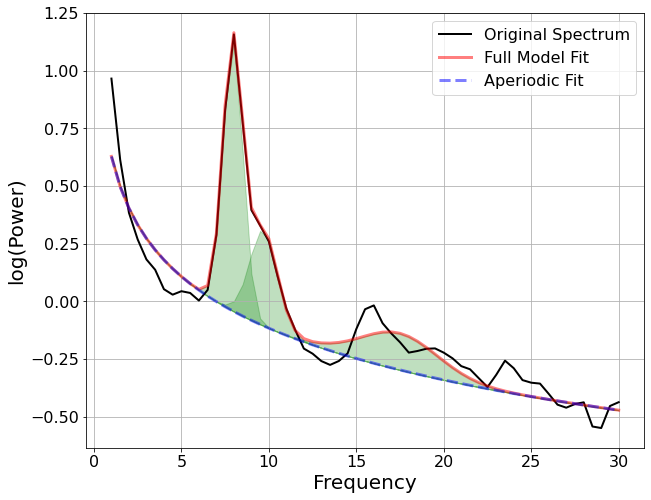

In [3]:
import os, mne
import pandas as pd
from fooof import FOOOF

from signal_processing.spectral_analysis import calculate_psd
from basic.arrange_data import read_files,create_results_folders

clean_folder = r"Data\Clean"
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,"_clean-epo.fif")
df_fooof = pd.DataFrame(index=subject_names,columns=['Exponent','Offset','Peaks_CF','Peaks_PW','Peaks_BW','R_2','Error'])

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)

    # Calculate Welch's power spectrum density (FFT)
    [psds,freqs] = calculate_psd(epochs,subject_names[i],fminmax=freq_range,window='hamming',
                                 window_duration=2,window_overlap=0.5,plot=False)

    psds_mean_all = psds.mean(axis=(0,1))

    # Initialize power spectrum model objects and fit the power spectra
    fm = FOOOF(min_peak_height=0.05, verbose=False)
    fm.fit(freqs,psds_mean_all,freq_range)
    #fm.print_results()
    try:
        fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})
    except:
        fm.plot()
    # Add model parameters to dataframe
    df_fooof.loc[df_fooof.index[i],'Exponent'] = fm.get_params('aperiodic_params','exponent')
    df_fooof.loc[df_fooof.index[i],'Offset'] = fm.get_params('aperiodic_params','offset')
    df_fooof.loc[df_fooof.index[i],'Peaks_CF'] = fm.get_params('peak_params', 'CF')
    df_fooof.loc[df_fooof.index[i],'Peaks_PW'] = fm.get_params('peak_params', 'PW')
    df_fooof.loc[df_fooof.index[i],'Peaks_BW'] = fm.get_params('peak_params', 'BW')
    df_fooof.loc[df_fooof.index[i],'R_2'] = fm.get_params('r_squared')
    df_fooof.loc[df_fooof.index[i],'Error'] = fm.get_params('error')

display(df_fooof)

# Pre-create results folders for spectral analysis data
create_results_folders('')

# Export asymmetry data
df_fooof.to_excel(r"Results\FOOOF\{}_fooof.xlsx".format(exp_condition))